In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import gensim
import numpy as np
import json
from brand.debiasing import EmbeddingDebias
from brand.utils import get_embedding_mat

# load definition words
gender_cfg_file = '../vocab/gender.json'
with open(gender_cfg_file, 'r') as f:
    cfg = json.load(f)
    gender_ds = cfg['definite_sets']

country_cfg_file = '../vocab/country_us_japan.json'
with open(country_cfg_file, 'r') as f:
    cfg = json.load(f)
    country_ds = cfg['definite_sets']

In [2]:
# load word vector model
pretrained_embedding_file = '../data/GoogleNews-vectors-negative300.bin.gz'
kv = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embedding_file, binary=True, limit=500000)

In [3]:
# prepare definitial (direction) matrix
gender_dmat = []
for _, words in enumerate(gender_ds):
    mat = get_embedding_mat(words, kv)
    gender_dmat.append(np.asarray(mat))

country_dmat = []
for _, words in enumerate(country_ds):
    mat = get_embedding_mat(words, kv)
    country_dmat.append(np.asarray(mat))

In [4]:
# create two debiasing workers
method = 'Hard'
k = 1
gender_debias = EmbeddingDebias(gender_dmat, embedding=kv, k=k, method=method)
country_debias = EmbeddingDebias(country_dmat, embedding=kv, k=k, method=method)

In [5]:
# dot product between two direction vectors
print('Dot product between two directions:', gender_debias._B.reshape(-1,).dot(country_debias._B.reshape(-1,)))

Dot product between two directions: -0.02516441


In [86]:
# brand list:
brands_japan = ['SONY', 'Shiseido', 'Nikon', 'Canon', 'TOSHIBA', 'Kao', 'Kose', 'Muji', 'Daiso', 'Okamoto', 'Uniqlo', 'SHIPS', 'Capcom', 'Daihatsu', 'JVC', 'Casio', 'Daikin', 'Nintendo', 'PlayStation', 'Yonex', 'Toyota']
brands_US = ['Google', 'Apple',  'Amazon', 'Microsoft', 'Marlboro', 'Outlier', 'Reformation','Pacifica', 'Sephora', 'Zippo', 'Cartier', 'Tesla', 'SpaceX', 'NASA', 'Ford', 'Boeing', 'Uber', ]

# check whether these words has pre-trained embeddings in w2vNews
for brand in brands_japan+brands_US:
    try:
        embedding = kv[brand]
    except:
        print('{} not found.'.format(brand))
        continue

In [87]:
# project onto the gender-country plane
brands = brands_japan + brands_US
gender_direction = gender_debias._B.reshape(-1,)
country_direction = country_debias._B.reshape(-1,)
c_gender = []
c_country = []
for brand in brands:
    coordinate_gender = kv[brand].dot(gender_direction)
    coordiante_country = kv[brand].dot(country_direction)
    c_gender.append(coordinate_gender)
    c_country.append(coordiante_country)
print(c_gender)
print(c_country)

[0.22810243, 0.80453193, 0.08974015, -0.102816164, 0.0044958442, 0.12665643, -0.04208748, 0.22719401, 0.2589335, 0.049598068, 0.54498374, -0.10838881, 0.4451503, 0.44001085, -0.01642435, 0.1531106, -0.015033014, 0.31709114, 0.16871305, 0.08284293, -0.11378345, 0.3142137, 0.11525201, 0.5521182, 0.039237224, -0.11155926, -0.0064204037, 0.08586731, 0.16984911, 0.8711003, -0.121692546, 0.40341341, 0.029074356, 0.29531217, 0.2840322, -0.12778234, 0.11210568, 0.043362014]
[-0.5698813, -1.2406288, -0.76663136, -0.57871455, -0.66758025, -1.0663055, -0.5811498, -0.8064698, -1.0031413, -1.6585577, -1.3865628, -0.4059268, -1.0614573, -1.1674931, -0.75727916, -0.72550213, -0.89886236, -1.169864, -0.74571466, -0.6038901, -0.96622646, -0.48590118, -0.36215886, -0.3540784, -0.57577264, 0.15797149, 0.30006218, 0.14955524, -0.37821767, 0.30041403, 0.1281285, -0.0018777549, -0.7198695, -0.43444765, -0.3522237, -0.027242359, -0.31227797, -0.01578629]


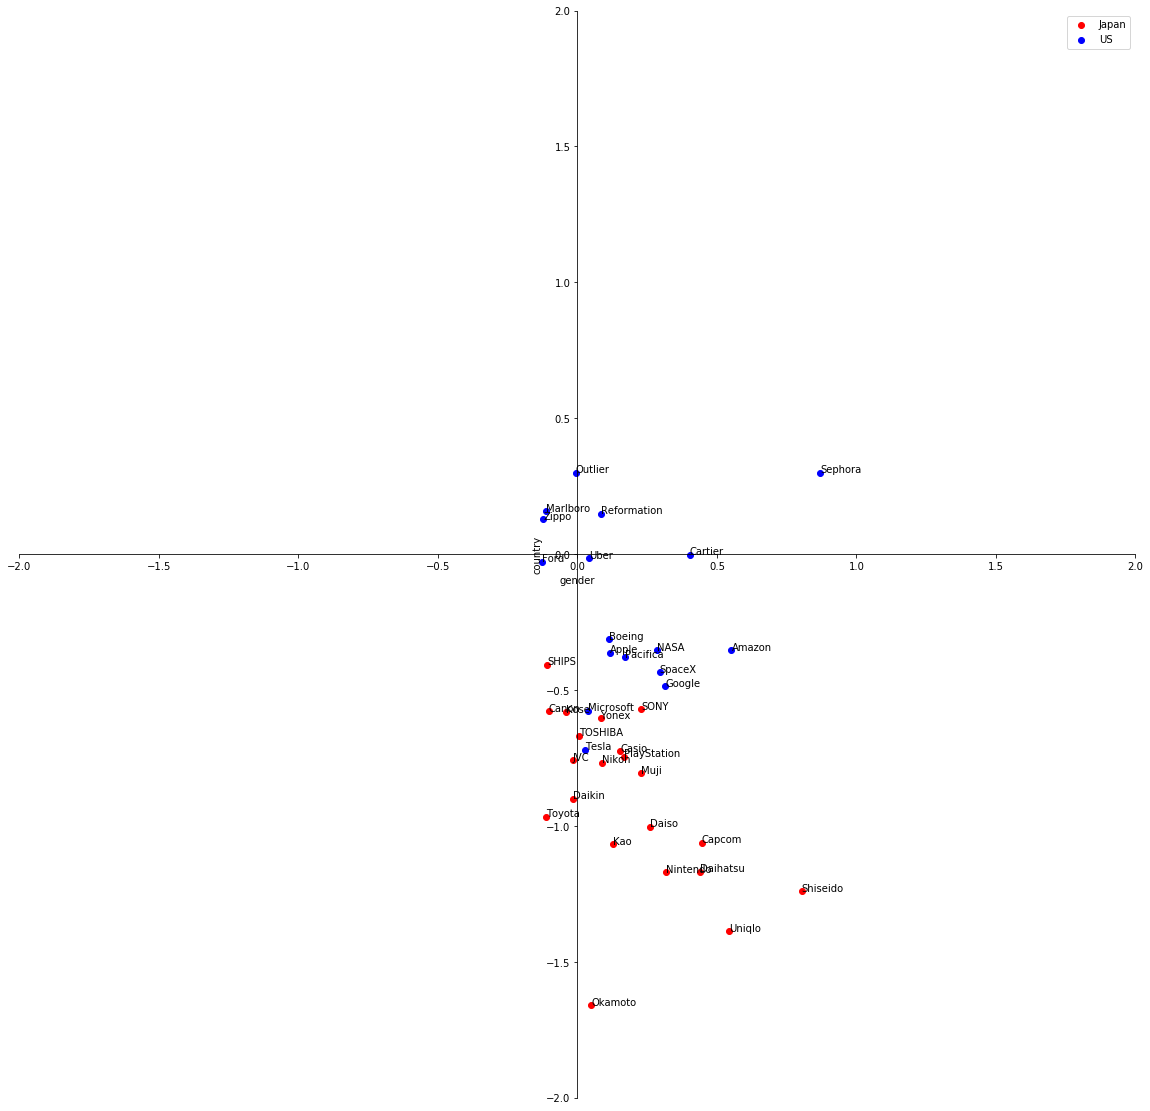

In [89]:
# plot on the gender-country 2D plane
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

split = len(brands_japan)
ax.scatter(x=c_gender[:split], y=c_country[:split], c='r', label='Japan')
ax.scatter(x=c_gender[split:], y=c_country[split:], c='b', label='US')
ax.set_xlabel('gender')
ax.set_ylabel('country')
brands = brands_japan + brands_US
for i, brand in enumerate(brands):
    ax.annotate(brand, (c_gender[i], c_country[i]))
ax.legend()
fig.savefig('../figures/gender_vs_country(Japan-US).png')
plt.show()